# 2019년 10월 이커머스 데이터 EDA

In [22]:
# pip install plotly==5.8.0

In [19]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from dateutil.parser import parse

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'

In [2]:
# org_df = pd.read_csv("D:/cp2_dataset/2019-Oct.csv")
# df = org_df.copy()

In [10]:
# csv -> parquet 파일로 변환
# df.to_parquet("D:/cp2_dataset/df.parquet", engine="pyarrow", compression="gzip")

In [2]:
# parquet 파일 읽기
df = pd.read_parquet('D:/cp2_dataset/df.parquet', engine='pyarrow')

## event_time 컬럼 나누기

In [3]:
# event_time 컬럼 타입 str -> datetime64로 변경
df["event_time"] = pd.to_datetime(df["event_time"])

In [4]:
df["event_time"]

0          2019-10-01 00:00:00+00:00
1          2019-10-01 00:00:00+00:00
2          2019-10-01 00:00:01+00:00
3          2019-10-01 00:00:01+00:00
4          2019-10-01 00:00:04+00:00
                      ...           
42448759   2019-10-31 23:59:58+00:00
42448760   2019-10-31 23:59:58+00:00
42448761   2019-10-31 23:59:58+00:00
42448762   2019-10-31 23:59:59+00:00
42448763   2019-10-31 23:59:59+00:00
Name: event_time, Length: 42448764, dtype: datetime64[ns, UTC]

In [5]:
# event_time 열 timezone UTC -> Asia/Dubai로 변경 (GMT +4)
df["event_time"] = df["event_time"].apply(lambda x : x.tz_convert("Asia/Dubai"))

In [6]:
df["event_time"]

0          2019-10-01 04:00:00+04:00
1          2019-10-01 04:00:00+04:00
2          2019-10-01 04:00:01+04:00
3          2019-10-01 04:00:01+04:00
4          2019-10-01 04:00:04+04:00
                      ...           
42448759   2019-11-01 03:59:58+04:00
42448760   2019-11-01 03:59:58+04:00
42448761   2019-11-01 03:59:58+04:00
42448762   2019-11-01 03:59:59+04:00
42448763   2019-11-01 03:59:59+04:00
Name: event_time, Length: 42448764, dtype: datetime64[ns, Asia/Dubai]

In [7]:
# event_time 월, 일, 요일, 시 빼내기
df["month"] = df["event_time"].dt.month
df["day"] = df["event_time"].dt.day
df["day_name"] = df["event_time"].apply(lambda x : x.day_name())
df["hour"] = df["event_time"].dt.hour

In [8]:
df.shape

(42448764, 13)

In [9]:
df.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session', 'month',
       'day', 'day_name', 'hour'],
      dtype='object')

In [10]:
column_order = ['event_time', 'month', 'day', 'day_name', 'hour', 
                'event_type', 'product_id', 'category_id', 'category_code', 
                'brand', 'price', 'user_id', 'user_session']
df_mod = df[column_order]

In [11]:
df_mod.head()

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 04:00:00+04:00,10,1,Tuesday,4,view,44600062,2103807459595387724,None,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 04:00:00+04:00,10,1,Tuesday,4,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 04:00:01+04:00,10,1,Tuesday,4,view,17200506,2053013559792632471,furniture.living_room.sofa,None,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 04:00:01+04:00,10,1,Tuesday,4,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 04:00:04+04:00,10,1,Tuesday,4,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


## parquet 파일 저장 후 작업 개시

In [13]:
# event_time 컬럼 변경한 것 parquet 파일로 저장
df_mod.to_parquet("D:/cp2_dataset/df.parquet", engine="pyarrow", compression="gzip")

In [2]:
mod = pd.read_parquet('D:/cp2_dataset/df.parquet', engine='pyarrow')

In [3]:
mod.head()

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 04:00:00+04:00,10,1,Tuesday,4,view,44600062,2103807459595387724,None,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 04:00:00+04:00,10,1,Tuesday,4,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 04:00:01+04:00,10,1,Tuesday,4,view,17200506,2053013559792632471,furniture.living_room.sofa,None,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 04:00:01+04:00,10,1,Tuesday,4,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 04:00:04+04:00,10,1,Tuesday,4,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [4]:
mod["event_type"].value_counts(normalize=True)

view        0.960673
cart        0.021827
purchase    0.017500
Name: event_type, dtype: float64

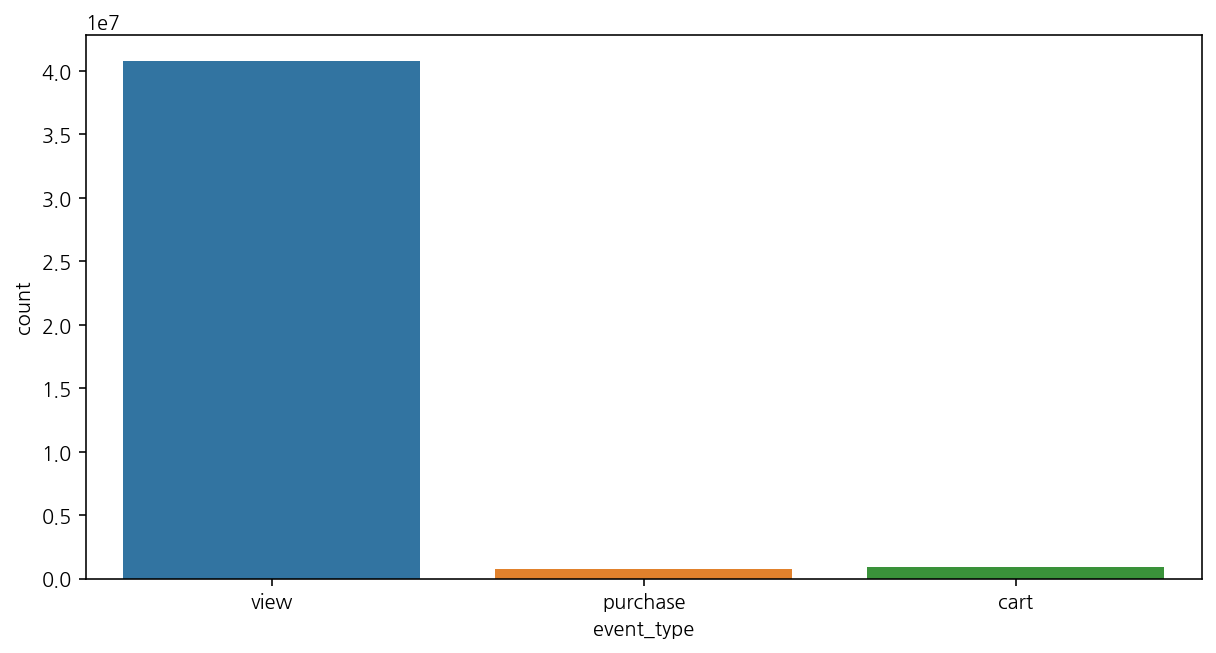

In [5]:
# event_type 분포
plt.figure(figsize=(10, 5))
cnt = sns.countplot(x=mod["event_type"])
plt.show()

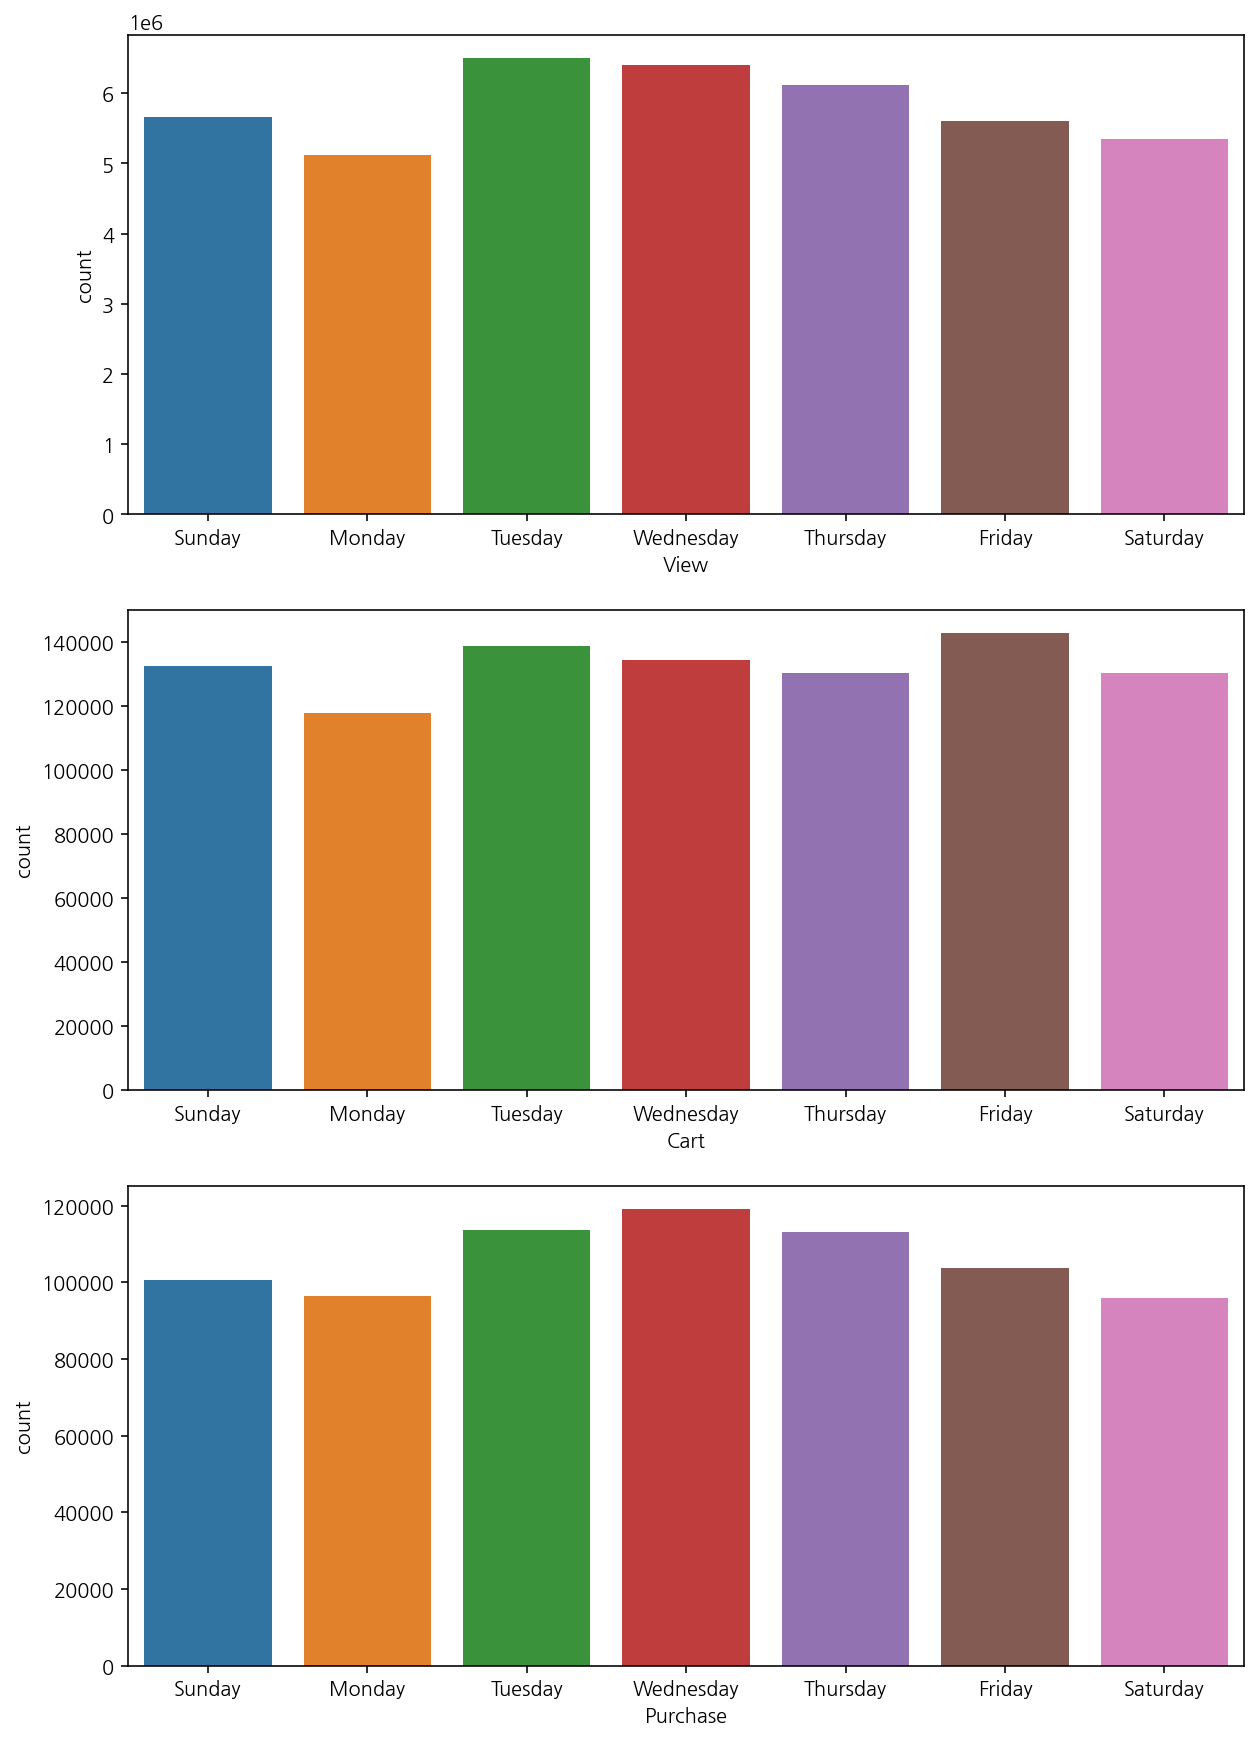

In [37]:
# 상품 클릭, 장바구니, 구매 조건 설정
view_cond = (mod["event_type"] == "view")
cart_cond = (mod["event_type"] == "cart")
purchase_cond = (mod["event_type"] == "purchase")

# 조건별로 countplot 생성
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# 요일별 상품 클릭한 숫자
view_cnt = sns.countplot(x=mod[view_cond]["day_name"],
                         order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],              ax=ax[0])
view_cnt.set_xlabel("View")

# 요일별 장바구니에 넣은 숫자
cart_cnt = sns.countplot(x=mod[cart_cond]["day_name"],
                         order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
                         ax=ax[1])
cart_cnt.set_xlabel("Cart")

# 요일별 구매한 숫자
purchase_cnt = sns.countplot(x=mod[purchase_cond]["day_name"],
                             order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
                             ax=ax[2])
purchase_cnt.set_xlabel("Purchase")

plt.show()

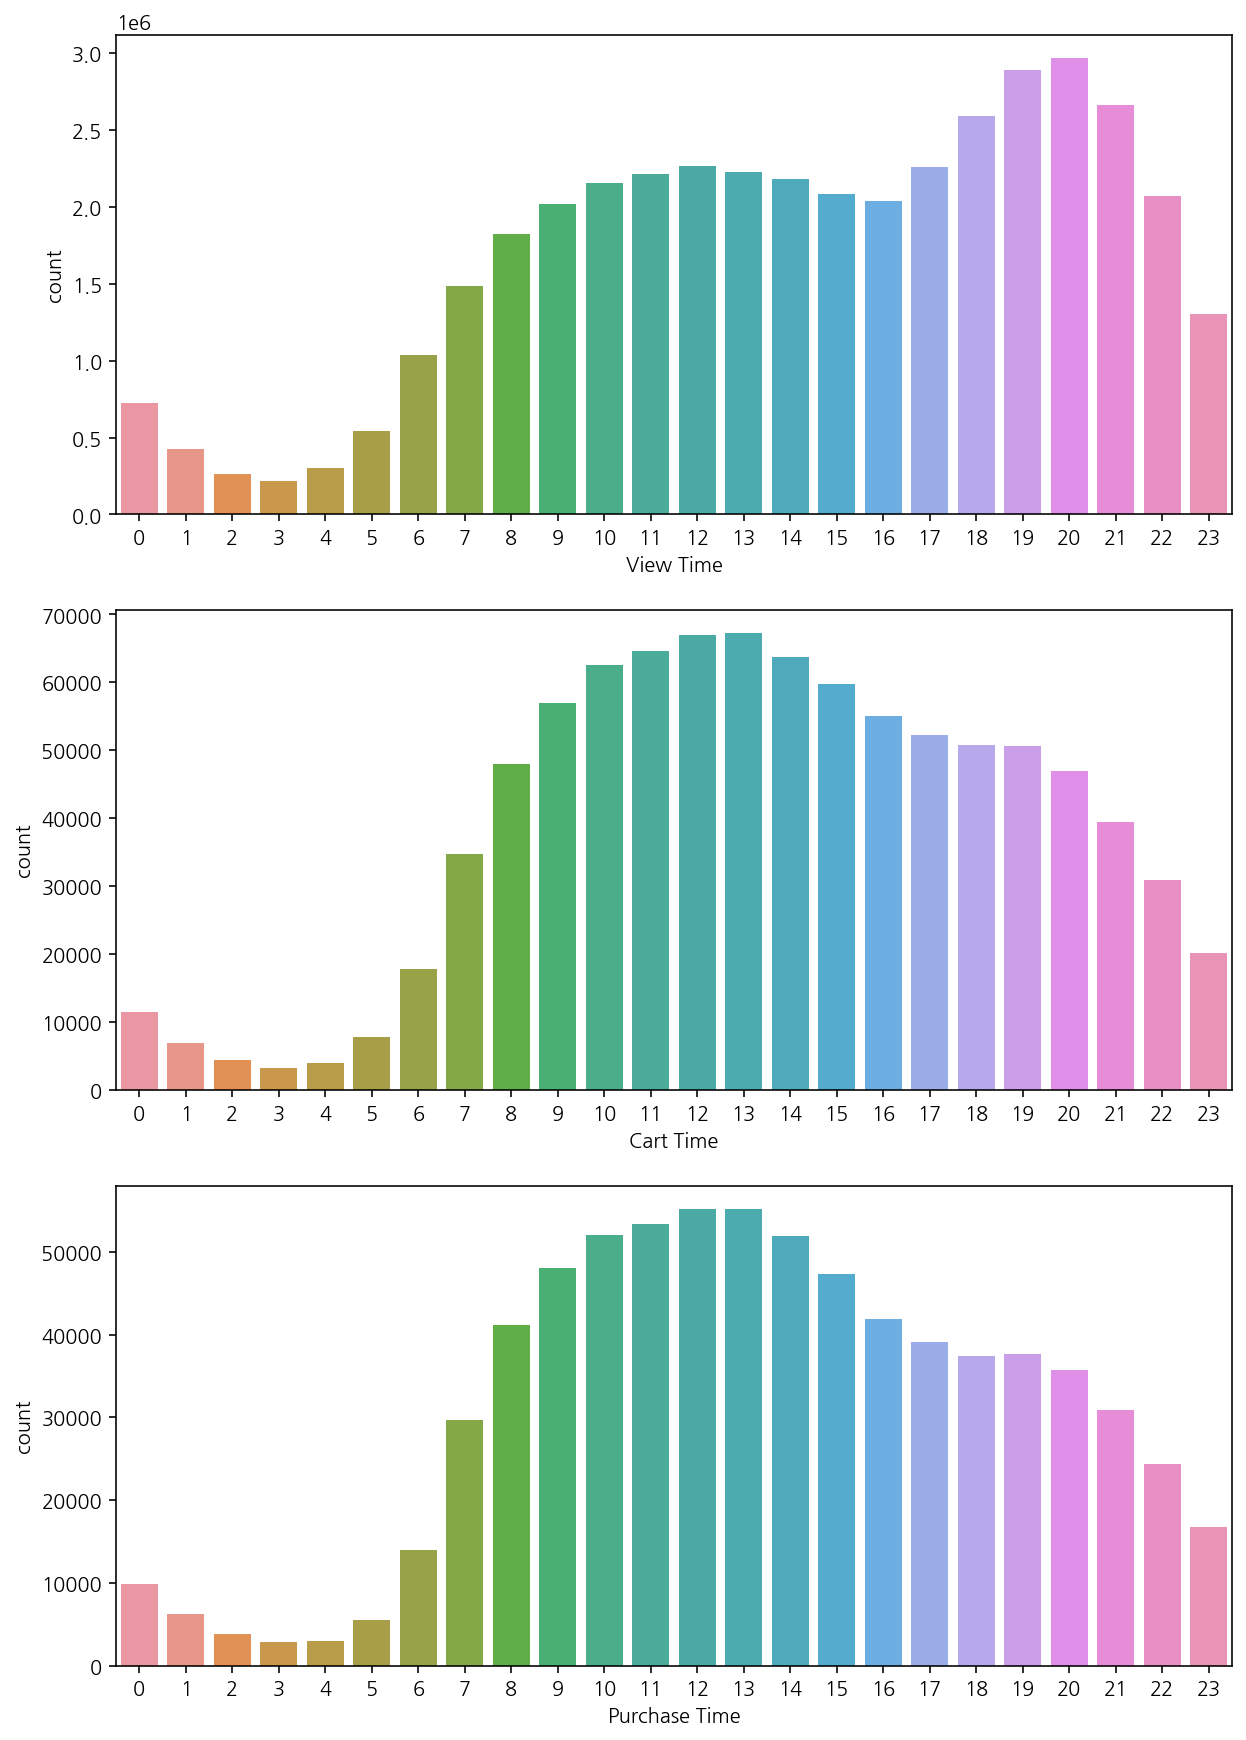

In [38]:
# 시간대별 View, Cart, Purchase

# 조건별로 countplot 생성
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# 요일별 상품 클릭한 숫자
view_time_cnt = sns.countplot(x=mod[view_cond]["hour"],
                              ax=ax[0])
view_time_cnt.set_xlabel("View Time")

# 요일별 장바구니에 넣은 숫자
cart_time_cnt = sns.countplot(x=mod[cart_cond]["hour"],
                         ax=ax[1])
cart_time_cnt.set_xlabel("Cart Time")

# 요일별 구매한 숫자
purchase_time_cnt = sns.countplot(x=mod[purchase_cond]["hour"],
                             ax=ax[2])
purchase_time_cnt.set_xlabel("Purchase Time")

plt.show()

## category_code TOP 10 분석

In [21]:
# 카테고리 코드 TOP 10
mod["category_code"].value_counts()[:10]

electronics.smartphone              11507231
electronics.clocks                   1311033
computers.notebook                   1137623
electronics.video.tv                 1113750
electronics.audio.headphone          1100188
appliances.kitchen.refrigerators      887755
appliances.kitchen.washer             869404
appliances.environment.vacuum         801670
apparel.shoes                         763901
auto.accessories.player               470208
Name: category_code, dtype: int64

In [7]:
# 대분류 TOP 10
main_cat = mod["category_code"].str.split(".").str[0].value_counts()[:10]
main_cat

electronics     16135623
appliances       4967294
computers        2324217
apparel          1542924
furniture        1247160
auto             1013115
construction      730834
kids              520619
accessories       238238
sport             176616
Name: category_code, dtype: int64

In [8]:
# 중분류 TOP 10
sub_cat_1st = mod["category_code"].str.split(".").str[1].value_counts()[:10]
sub_cat_1st

smartphone     11507231
kitchen         3531445
audio           1574674
clocks          1311033
shoes           1208383
environment     1147634
notebook        1137623
video           1126904
accessories     1013115
tools            719816
Name: category_code, dtype: int64

In [9]:
# 소분류 TOP 10
sub_cat_2nd = mod["category_code"].str.split(".").str[2].value_counts()[:10]
sub_cat_2nd

tv               1113750
headphone        1100188
refrigerators     887755
washer            869404
vacuum            801670
player            470208
keds              410304
bed               358453
subwoofer         313664
cabinet           301410
Name: category_code, dtype: int64

In [77]:
# 브랜드 TOP 10
brand_top10 = mod["brand"].value_counts()[:10]
brand_top10

samsung    5282775
apple      4122554
xiaomi     3083763
huawei     1111205
lucente     655861
lg          562404
bosch       557090
oppo        482887
sony        456644
acer        428153
Name: brand, dtype: int64

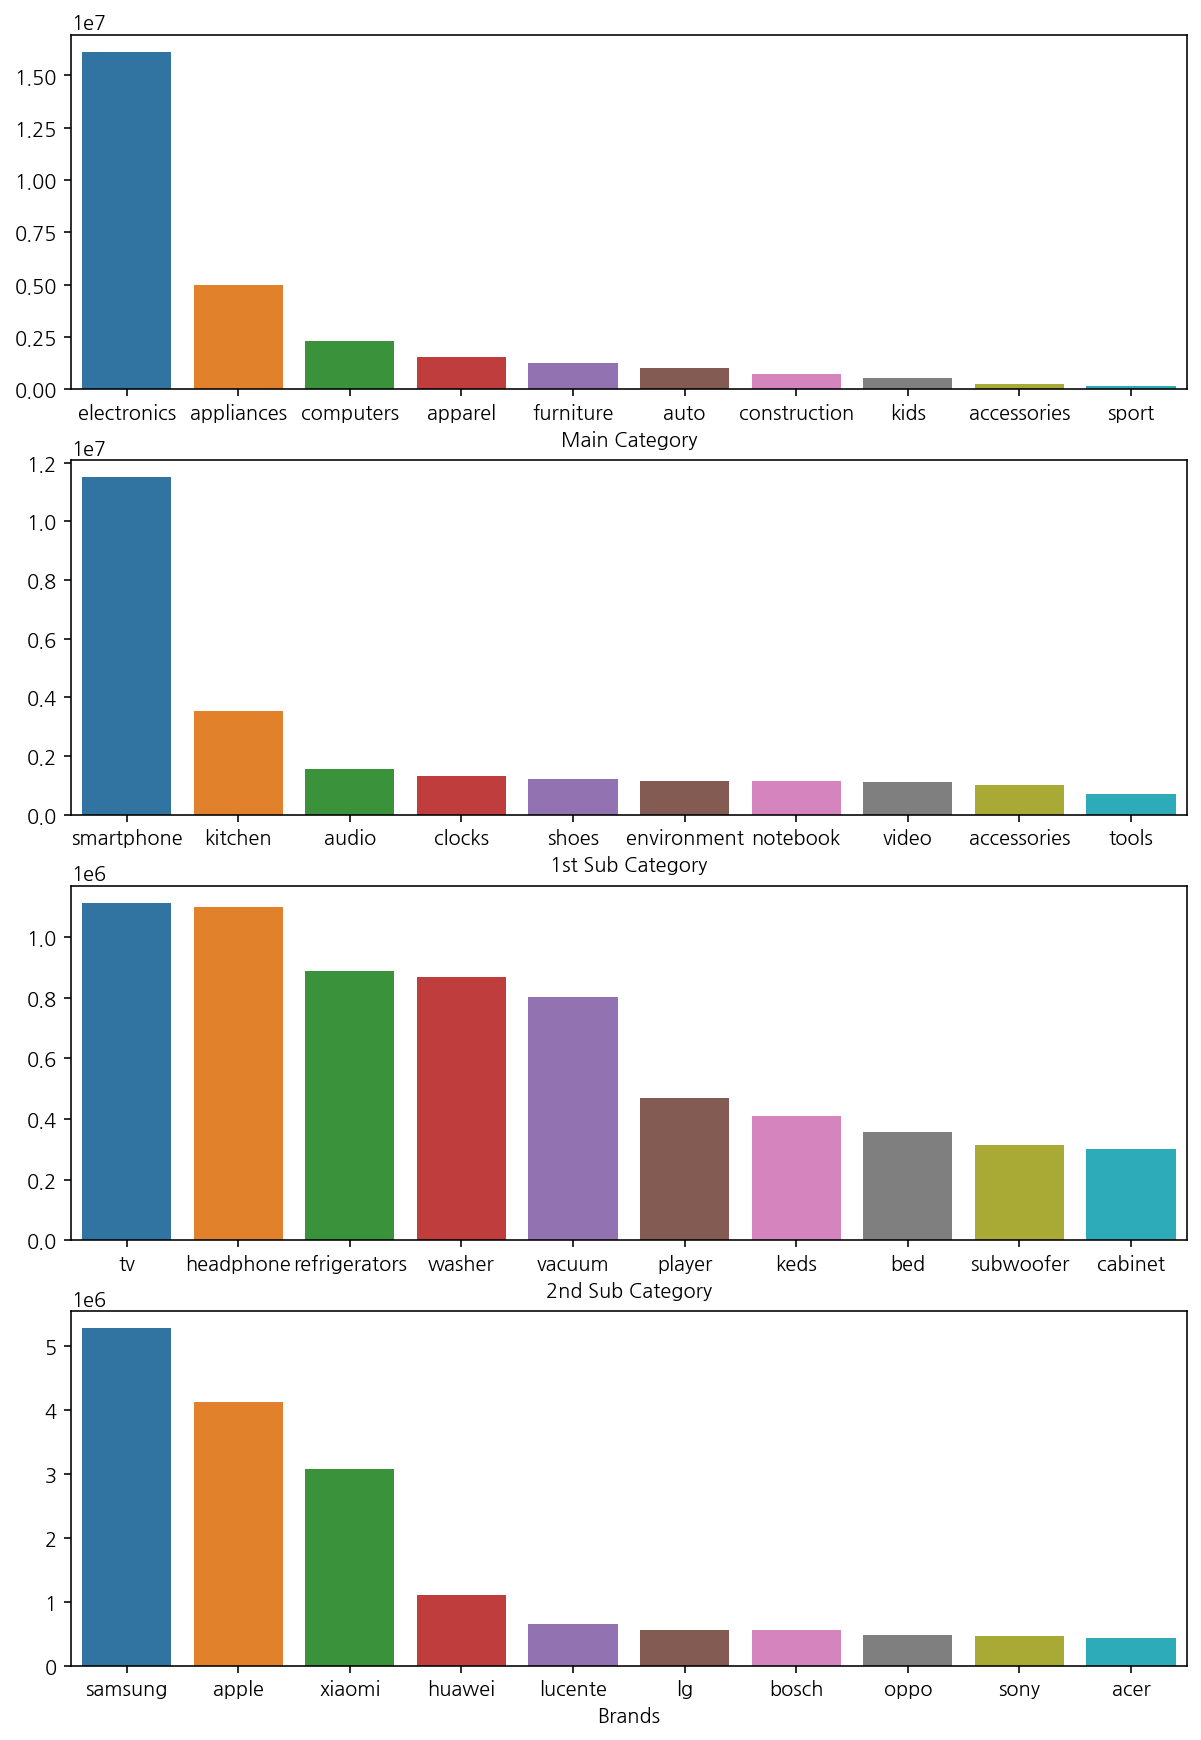

In [81]:
# 카테고리별 TOP 10 (대분류, 중분류, 소분류), 브랜드 TOP 10

# 조건별로 plot 생성
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 15))

# 메인 카테고리 (대분류) Top 10
main_bar = sns.barplot(x=main_cat.index, 
                       y=main_cat.values,
                       ax=ax[0])
main_bar.set_xlabel("Main Category")

# 중분류 Top 10
sub_1st_bar = sns.barplot(x=sub_cat_1st.index,
                          y=sub_cat_1st.values,
                          ax=ax[1])
sub_1st_bar.set_xlabel("1st Sub Category")

# 소분류 Top 10
sub_2nd_bar = sns.barplot(x=sub_cat_2nd.index,
                          y=sub_cat_2nd.values,
                          ax=ax[2])
sub_2nd_bar.set_xlabel("2nd Sub Category")

# 브랜드 Top 10
brand_bar = sns.barplot(x=brand_top10.index,
                        y=brand_top10.values,
                        ax=ax[3])
brand_bar.set_xlabel("Brands")

plt.show()

In [22]:
mod.head()

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 04:00:00+04:00,10,1,Tuesday,4,view,44600062,2103807459595387724,None,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 04:00:00+04:00,10,1,Tuesday,4,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 04:00:01+04:00,10,1,Tuesday,4,view,17200506,2053013559792632471,furniture.living_room.sofa,None,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 04:00:01+04:00,10,1,Tuesday,4,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 04:00:04+04:00,10,1,Tuesday,4,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [62]:
cond = (mod["category_code"].isna()) | (mod["brand"].isna())
mod[cond]["brand"].value_counts().head(20)

lucente     655861
xiaomi      386119
cordiant    368277
sony        235406
stels       231895
bosch       227255
triangle    212952
nokian      185123
force       166369
redmond     153856
samsung     123872
philips     115976
yokohama    115014
dauscher    113601
omabelle    111826
artel       100935
skad         98592
sokolov      98409
vitek        97454
polaris      94692
Name: brand, dtype: int64

In [74]:
lucente = (mod["brand"] == "lucente")
# mod[lucente]["category_code"].value_counts()
mod[lucente]["price"].value_counts().sort_index(ascending=False)

887.28     262
845.84      18
832.20    3202
784.58      16
782.00    6864
          ... 
11.33       29
10.81      347
10.30      122
10.04       30
9.52        28
Name: price, Length: 672, dtype: int64

In [75]:
mod[lucente]

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
53,2019-10-01 04:00:42+04:00,10,1,Tuesday,4,view,26400291,2053013563651392361,None,lucente,188.94,551331813,19ded3e3-823b-4f51-ad00-ab84f364f5ef
58,2019-10-01 04:00:44+04:00,10,1,Tuesday,4,view,26500313,2053013563550729061,None,lucente,267.19,525856698,f72ea16b-4ec3-44f8-8fcd-35d89984b744
85,2019-10-01 04:01:12+04:00,10,1,Tuesday,4,view,26500144,2053013563550729061,None,lucente,259.21,525856698,f72ea16b-4ec3-44f8-8fcd-35d89984b744
150,2019-10-01 04:02:05+04:00,10,1,Tuesday,4,view,26201000,2053013563693335403,None,lucente,106.31,555447748,b50d1ae8-1948-4517-8460-09b7601ceef6
264,2019-10-01 04:03:46+04:00,10,1,Tuesday,4,view,26300089,2053013563584283495,None,lucente,271.82,552985520,7e776b9d-4f32-494f-9fbe-f293046cdd6c
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42447923,2019-11-01 03:53:37+04:00,11,1,Friday,3,view,26300188,2053013563584283495,None,lucente,709.67,497681858,900fe3e7-a6b3-49f6-9a9c-a8847822f75a
42448006,2019-11-01 03:54:15+04:00,11,1,Friday,3,view,26404396,2053013563651392361,None,lucente,58.43,564353057,b916c35a-600b-4d21-ad90-5b196a3811b1
42448291,2019-11-01 03:56:11+04:00,11,1,Friday,3,view,26400291,2053013563651392361,None,lucente,200.26,565098257,dfbfd3f3-9347-45a1-b572-ec3897d327dc
42448464,2019-11-01 03:57:44+04:00,11,1,Friday,3,view,26400686,2053013563651392361,None,lucente,406.45,533351761,6229f7bc-7440-44dc-8768-d924071fb879


In [40]:
xiao = (mod["brand"] == "xiaomi")
xiao_none = (mod["brand"] == "xiaomi") & (mod["category_code"].isna())
mod[xiao_none]["price"].value_counts().head(30)

28.42     20833
27.61     16326
29.09     13886
28.55      9327
28.80      8980
28.73      8879
28.56      8761
28.95      8451
28.31      7359
48.14      6027
29.01      5758
29.54      5311
28.28      5088
102.70     4280
29.56      4146
21.85      3929
21.09      3725
81.86      3578
78.51      3356
76.94      3327
28.69      3207
20.34      3113
28.36      3078
28.30      3026
22.96      3000
22.88      2981
28.44      2905
29.51      2885
29.58      2842
29.08      2839
Name: price, dtype: int64

In [83]:
xiao_20 = (mod["brand"] == "xiaomi") & (mod["price"] >= 20) & (mod["price"] < 30)
mod[xiao_20]["category_code"].value_counts()

electronics.audio.headphone     125972
appliances.personal.scales        4330
appliances.kitchen.kettle          840
accessories.umbrella               806
accessories.bag                    782
computers.peripherals.mouse        420
construction.tools.light           410
furniture.bedroom.pillow           138
construction.tools.generator        22
stationery.cartrige                  1
Name: category_code, dtype: int64

In [49]:
xiao_75 = (mod["brand"] == "xiaomi") & (mod["price"] >= 75) & (mod["price"] < 80)
mod[xiao_75]["category_code"].value_counts()

electronics.audio.headphone    4161
electronics.smartphone         1864
electronics.clocks              802
auto.accessories.compressor     365
Name: category_code, dtype: int64

In [50]:
xiao_70 = (mod["brand"] == "xiaomi") & (mod["price"] >= 70) & (mod["price"] < 75)
mod[xiao_70]["category_code"].value_counts()

electronics.audio.headphone       16405
electronics.clocks                15853
auto.accessories.videoregister    13948
electronics.smartphone            10829
Name: category_code, dtype: int64

In [82]:
mod[xiao_70]["price"].sort_values(ascending=False)

35043457    74.97
35188585    74.97
35131829    74.97
35131321    74.97
35125458    74.97
            ...  
37973194    70.13
38295010    70.13
38297264    70.13
38297528    70.13
38109054    70.13
Name: price, Length: 59850, dtype: float64

In [15]:
# event_time 월만 빼내기
df["event_time"].dt.month

0           10
1           10
2           10
3           10
4           10
            ..
42448759    11
42448760    11
42448761    11
42448762    11
42448763    11
Name: event_time, Length: 42448764, dtype: int64

In [16]:
# event_time 일만 빼내기
df["event_time"].dt.day

0           1
1           1
2           1
3           1
4           1
           ..
42448759    1
42448760    1
42448761    1
42448762    1
42448763    1
Name: event_time, Length: 42448764, dtype: int64

In [17]:
# event_time 시간만 빼내기
df["event_time"].dt.hour

0           4
1           4
2           4
3           4
4           4
           ..
42448759    3
42448760    3
42448761    3
42448762    3
42448763    3
Name: event_time, Length: 42448764, dtype: int64

In [18]:
# event_time 분만 빼내기
df["event_time"].dt.minute

0            0
1            0
2            0
3            0
4            0
            ..
42448759    59
42448760    59
42448761    59
42448762    59
42448763    59
Name: event_time, Length: 42448764, dtype: int64

In [19]:
# event_time 요일 이름만 빼내기
df["event_time"].apply(lambda x : x.day_name())

0           Tuesday
1           Tuesday
2           Tuesday
3           Tuesday
4           Tuesday
             ...   
42448759     Friday
42448760     Friday
42448761     Friday
42448762     Friday
42448763     Friday
Name: event_time, Length: 42448764, dtype: object

In [6]:
1+10

11

In [20]:
df["category_code"].str.split(".").str[0]

MemoryError: 